In [1]:
import awkward as ak
from coffea import processor
from coffea.nanoevents.methods import candidate
import hist
import uproot
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.nanoevents.methods.vector import PtEtaPhiMLorentzVector
from coffea.nanoevents.methods import nanoaod
import matplotlib.pyplot as plt
import json
import numpy as np

In [2]:
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        dataset = events.metadata['dataset']
        filename = events.metadata['filename']

        topmatched_mass = (
            hist.Hist.new
            .Regular(100, 0.2, 200., name="mass", label="$\mu$ mass [GeV]")
            .Regular(100, 0., 2000., name="pt", label="$\mu$ pt [GeV]")
            .Int64()
        )
        
        wmatched_mass = (
            hist.Hist.new
            .Regular(100, 0.2, 200., name="mass", label="$\mu$ mass [GeV]")
            .Regular(100, 0., 2000., name="pt", label="$\mu$ pt [GeV]")
            .Int64()
        )
        
        unmatched_mass = (
            hist.Hist.new
            .Regular(100, 0.2, 200., name="mass", label="$\mu$ mass [GeV]")
            .Regular(100, 0., 2000., name="pt", label="$\mu$ pt [GeV]")
            .Int64()
        )
        
        data_mass = (
            hist.Hist.new
            .Regular(100, 0.2, 200., name="mass", label="$\mu$ mass [GeV]")
            .Regular(100, 0., 2000., name="pt", label="$\mu$ pt [GeV]")
            .Int64()
        )
        
        other_mass = (
            hist.Hist.new
            .Regular(100, 0.2, 200., name="mass", label="$\mu$ mass [GeV]")
            .Regular(100, 0., 2000., name="pt", label="$\mu$ pt [GeV]")
            .Int64()
        )
        
        if 'TTToSemiLeptonic' in filename:
            ak.behavior.update(nanoaod.behavior)

            fatjets = ak.zip({"pt": events.fatjet_pt,
                              "eta": events.fatjet_eta,
                              "phi": events.fatjet_phi,
                              "mass": events.fatjet_mass,
                              "btagScore": events.fatjet_doubleBTag,
                              "dr_T": events.fatjet_1_dr_T,
                              "dr_T_Wq_max": events.fatjet_1_dr_T_Wq_max,
                              "dr_T_Wq_max": events.fatjet_1_dr_T_Wq_max,
                              "T_Wq_max_pdgId": events.fatjet_1_T_Wq_max_pdgId,
                              "dr_W_daus": events.fatjet_1_dr_W_daus,
                              "dr_T_b": events.fatjet_1_dr_T_b,},
                             with_name="PtEtaPhiMLorentzVector",)

            jets = ak.zip({"pt": events.jet_pt,
                              "eta": events.jet_eta,
                              "phi": events.jet_phi,
                              "mass": events.jet_m,
                              "btagScore": events.jet_bTagScore},
                             with_name="PtEtaPhiMLorentzVector",)

            muon = ak.zip({"pt": ak.firsts(events.muon_pt),
                              "eta": ak.firsts(events.muon_eta),
                              "phi": ak.firsts(events.muon_phi),
                              "mass": ak.firsts(events.muon_m),
                              "dz": ak.firsts(events.trk_dz),
                              "dxy": ak.firsts(events.trk_dxy)},
                             with_name="PtEtaPhiMLorentzVector",)

            met = ak.zip({"pt": events.met_pt,
                                "eta": None,
                                "phi": events.met_phi,
                                "mass": None},
                            with_name="PtEtaPhiMLorentzVector",)
            
            # muon selection
            muon_cut = ak.fill_none(
                        (muon.pt > 55)
                        & (abs(muon.eta) < 2.5)
                        & (abs(muon.dxy) < 0.2)
                        & (abs(muon.dz) < 0.5), False)
                           
            # met selection
            met_cut = ak.fill_none(met.pt > 50, False)
            
            # leptonic W pt cut
            leptonicW = met + muon
            w_cut = ak.fill_none(leptonicW.pt > 100, False)
            
            # at least one b-jet, in the same hemisphere of the muon
            dphi = abs(jets.delta_phi(muon))
            btag_cut = ak.fill_none(ak.any(jets[dphi < 2].btagScore < 100, axis=-1), False)
            
            # require fatjet away from the muon
            dphi = abs(fatjets.delta_phi(muon))
            fatjet_muon_cut =ak.fill_none(ak.all(dphi > 2, axis=-1), False)
            
            event_cut = (muon_cut & met_cut & w_cut & btag_cut & fatjet_muon_cut)
            
            # choose only the first fatjet that passes the event cut
            probe_jet = fatjets[event_cut][:,0]
            
            jetR = 1.6
            top = (probe_jet.dr_T_b < jetR) & (probe_jet.dr_T_Wq_max < jetR)
            W = ((probe_jet.T_Wq_max_pdgId == 0) & (probe_jet.dr_W_daus_np < jetR)) or ((probe_jet.T_Wq_max_pdgId_np != 0) & (probe_jet.dr_T_b_np >= jetR) & (probe_jet.dr_T_Wq_max_np < jetR))
            
            topmatched_mass.fill(mass=probe_jet[top].mass, pt=probe_jet[top].pt)
            wmatched_mass.fill(mass=probe_jet[W].mass, pt=probe_jet[W].pt)
            unmatched.fill(mass=probe_jet[(not top) and (not W)].mass, pt=probe_jet[(not top) and (not W)].pt)
            
        elif 'data' in filename:
            data_mass.fill(mass=ak.flatten(events.fatjet_mass), pt=ak.flatten(events.fatjet_pt))
        
        else:
            other_mass.fill(mass=ak.flatten(events.fatjet_mass), pt=ak.flatten(events.fatjet_pt))
            
        return {
            dataset: {
                "entries": len(events),
                "topmatched": topmatched_mass,
                "Wmatched": wmatched_mass,
                "unmatched": unmatched_mass,
                "data": data_mass,
                "other": other_mass,
            }
        }

    def postprocess(self, accumulator):
        pass

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


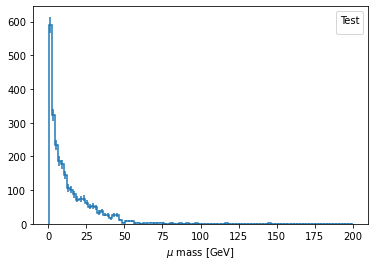

In [11]:
filename = "tt_Wb_qqb_numEvent100.root"
file = uproot.open(filename)
events = NanoEventsFactory.from_root(
    file,
    treepath="mmtree/tree",
    entry_stop=10000,
    metadata={"dataset": "DoubleMuon", "filename": filename},
    schemaclass=BaseSchema,
).events()
p = MyProcessor()
out = p.process(events)
out

fig, ax = plt.subplots()
out["DoubleMuon"]["other"].project("mass").plot1d(ax=ax)
#ax.set_xscale("log")
ax.legend(title="Test")